# Analyzing R package download frequency
Based on https://github.com/XD-DENG/Spark-practice, this notebook is licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

## Download data

In [0]:
!wget http://cran-logs.rstudio.com/2022/2022-11-12.csv.gz

--2022-11-14 11:54:05--  http://cran-logs.rstudio.com/2022/2022-11-12.csv.gz
Resolving cran-logs.rstudio.com (cran-logs.rstudio.com)... 52.92.194.27, 52.92.212.219, 52.218.192.171, ...
Connecting to cran-logs.rstudio.com (cran-logs.rstudio.com)|52.92.194.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54754355 (52M) [application/gzip]
Saving to: ‘2022-11-12.csv.gz’

2022-11-12.csv.gz   100%[===================>]  52.22M  61.9MB/s    in 0.8s    

2022-11-14 11:54:06 (61.9 MB/s) - ‘2022-11-12.csv.gz’ saved [54754355/54754355]



## Import data into an Resilient Distributed Dataset (RDD)

In [0]:
# A Spark Context "sc" is already made for us by Databricks.
# Note that we don't have to unzip the data file, `sc.textFile` does that for us.
# `sc.textFile` produces an RDD.

raw_content = sc.textFile("file:///databricks/driver/2022-11-12.csv.gz")
type(raw_content)

Out[49]: pyspark.rdd.RDD

## Data overview

In [0]:
# Let's have a look at a few lines.
raw_content.take(5)

Out[50]: ['"date","time","size","r_version","r_arch","r_os","package","version","country","ip_id"',
 '"2022-11-12","06:08:21",15293,NA,NA,NA,"fastmatch","1.1-3","US",1',
 '"2022-11-12","06:08:38",16547,NA,NA,NA,"praise","1.0.0","US",2',
 '"2022-11-12","06:08:31",3006918,"4.2.2","x86_64","darwin17.0","palmerpenguins","0.1.1","US",3',
 '"2022-11-12","06:08:32",459776,"4.2.2","x86_64","darwin17.0","mlr3viz","0.5.10","US",3']

In [0]:
# How many data lines do we have in total?
raw_content.count()

Out[51]: 4254544

## Intermezzo 1: Set Operations

In [0]:
# Combine two sets, for the case of the same set it results in twice the rows. You can compare that to the `count()` output above.
raw_content.union(raw_content).count()

Out[52]: 8509088

In [0]:
# Show only rows that are the same in both sets. Note that this is less than `raw_content.count()` due to duplicate lines.
raw_content.intersection(raw_content).count()

Out[53]: 4107223

In [0]:
# The above intersection with itself is the same as `distinct()` which shows only unique rows.
raw_content.distinct().count()

Out[54]: 4107223

## Data cleaning

In [0]:
# Turn the string lines from raw_content into an array.
content = raw_content.map(lambda x: x.split(','))

In [0]:
# The lines are split now.
content.take(5)

Out[56]: [['"date"',
  '"time"',
  '"size"',
  '"r_version"',
  '"r_arch"',
  '"r_os"',
  '"package"',
  '"version"',
  '"country"',
  '"ip_id"'],
 ['"2022-11-12"',
  '"06:08:21"',
  '15293',
  'NA',
  'NA',
  'NA',
  '"fastmatch"',
  '"1.1-3"',
  '"US"',
  '1'],
 ['"2022-11-12"',
  '"06:08:38"',
  '16547',
  'NA',
  'NA',
  'NA',
  '"praise"',
  '"1.0.0"',
  '"US"',
  '2'],
 ['"2022-11-12"',
  '"06:08:31"',
  '3006918',
  '"4.2.2"',
  '"x86_64"',
  '"darwin17.0"',
  '"palmerpenguins"',
  '"0.1.1"',
  '"US"',
  '3'],
 ['"2022-11-12"',
  '"06:08:32"',
  '459776',
  '"4.2.2"',
  '"x86_64"',
  '"darwin17.0"',
  '"mlr3viz"',
  '"0.5.10"',
  '"US"',
  '3']]

In [0]:
def clean(line):
    """Remove quotation marks " from data entries."""
    return([item.replace('"', '') for item in line])

content = content.map(clean)

# Now it looks much better.
content.take(5)

Out[57]: [['date',
  'time',
  'size',
  'r_version',
  'r_arch',
  'r_os',
  'package',
  'version',
  'country',
  'ip_id'],
 ['2022-11-12',
  '06:08:21',
  '15293',
  'NA',
  'NA',
  'NA',
  'fastmatch',
  '1.1-3',
  'US',
  '1'],
 ['2022-11-12',
  '06:08:38',
  '16547',
  'NA',
  'NA',
  'NA',
  'praise',
  '1.0.0',
  'US',
  '2'],
 ['2022-11-12',
  '06:08:31',
  '3006918',
  '4.2.2',
  'x86_64',
  'darwin17.0',
  'palmerpenguins',
  '0.1.1',
  'US',
  '3'],
 ['2022-11-12',
  '06:08:32',
  '459776',
  '4.2.2',
  'x86_64',
  'darwin17.0',
  'mlr3viz',
  '0.5.10',
  'US',
  '3']]

## Finding and Counting

In [0]:
# How often was 'ggplot2' downloaded?
ggplot2 = content.filter(lambda x: x[6] == 'ggplot2').count()
ggplot2

Out[58]: 75149

In [0]:
# You can filter for multiple fields at the same time.
ggplot2_nl = content.filter(lambda x: x[6] == 'ggplot2' and x[8] == 'NL')
ggplot2_nl

Out[59]: PythonRDD[169] at RDD at PythonRDD.scala:58

In [0]:
# Let's look at the filtered rows themselves.
ggplot2_nl.take(2)

Out[60]: [['2022-11-12',
  '10:03:20',
  '3148990',
  '4.2.0',
  'x86_64',
  'linux-gnu',
  'ggplot2',
  '3.4.0',
  'NL',
  '1598'],
 ['2022-11-12',
  '18:15:06',
  '4217460',
  '4.2.2',
  'x86_64',
  'mingw32',
  'ggplot2',
  '3.4.0',
  'NL',
  '2568']]

## Reduce
Filtering works nicely, but let's aggregate and count _all_ packages instead.

In [0]:
# A common way to "reduce" in Spark: Tie a field containing "1" to all lines and sum these fields per key.
package_count = content.map(lambda x: (x[6], 1)).reduceByKey(lambda a,b: a+b)
type(package_count)

Out[61]: pyspark.rdd.PipelinedRDD

In [0]:
# This is how the aggregate looks like now.
package_count.take(5)

Out[62]: [('package', 1),
 ('fastmatch', 1292),
 ('praise', 8210),
 ('palmerpenguins', 999),
 ('mlr3viz', 71)]

In [0]:
# We can still query the count of single packages.
package_count.lookup("XML")

Out[63]: [6988]

# Intermezzo 2: Joins
See https://javarevisited.blogspot.com/2013/05/difference-between-left-and-right-outer-join-sql-mysql.html for details about join flavours.

In [0]:
# Let's split out the country to use as a key.
content_modified=content.map(lambda x:(x[8], x))
content_modified.take(2)

Out[64]: [('country',
  ['date',
   'time',
   'size',
   'r_version',
   'r_arch',
   'r_os',
   'package',
   'version',
   'country',
   'ip_id']),
 ('US',
  ['2022-11-12',
   '06:08:21',
   '15293',
   'NA',
   'NA',
   'NA',
   'fastmatch',
   '1.1-3',
   'US',
   '1'])]

In [0]:
# Your mapping list can be as long as you like. As an example, we take two countries. 
mapping=[('NL', 'Netherlands'), ('US', 'United States')]

In [0]:
# Distribute the mapping to form an RDD.
mapping_rdd=sc.parallelize(mapping)

In [0]:
# For comparison with below commands: How many lines does `content_modified` have?
content_modified.count()

Out[67]: 4254544

In [0]:
# Performing an "inner join" operation. This is _shorter_ than `content_modified`, since an "inner join" only produces lines that share a key in both `content_modified` and `mapping_rdd`.
join = content_modified.join(mapping_rdd)
join.count()

Out[68]: 1650110

In [0]:
# This is what the data looks like. Notice that _all_ entries have matched with mapping_rdd and contain the country name as last field.
join.takeSample(withReplacement=False, num=2)

Out[69]: [('US',
  (['2022-11-12',
    '13:46:48',
    '1054655',
    'NA',
    'NA',
    'NA',
    'jsonlite',
    '1.8.3',
    'US',
    '57'],
   'United States')),
 ('US',
  (['2022-11-12',
    '12:42:10',
    '38617',
    '4.2.1',
    'x86_64',
    'linux-gnu',
    'codetools',
    '0.2-18',
    'US',
    '48037'],
   'United States'))]

In [0]:
# Performing a "left outer join" operation. This is exactly as long as `content_modified`, since the key only has to appear in the "left" (`content_modified`) set, and not necessarily in `mapping_rdd`.
left_outer_join = content_modified.leftOuterJoin(mapping_rdd)
left_outer_join.count()

Out[70]: 4254544

In [0]:
# Notice that not all lines have matched with `mapping_rdd`. These lines now contain `None` as last item.
left_outer_join.takeSample(False, 8)

Out[71]: [('AT',
  (['2022-11-12',
    '15:39:26',
    '46750',
    '4.2.2',
    'x86_64',
    'mingw32',
    'sys',
    '3.4.1',
    'AT',
    '45468'],
   None)),
 ('ZA',
  (['2022-11-12',
    '11:23:28',
    '2603983',
    '4.1.3',
    'x86_64',
    'mingw32',
    'data.table',
    '1.14.4',
    'ZA',
    '24751'],
   None)),
 ('RU',
  (['2022-11-12',
    '12:30:16',
    '33036',
    '4.2.2',
    'x86_64',
    'mingw32',
    'base64enc',
    '0.1-3',
    'RU',
    '62215'],
   None)),
 ('CN',
  (['2022-11-12',
    '05:50:29',
    '597319',
    '4.2.1',
    'x86_64',
    'mingw32',
    'ggrepel',
    '0.9.2',
    'CN',
    '13139'],
   None)),
 ('US',
  (['2022-11-12',
    '20:39:00',
    '84767',
    '4.2.1',
    'x86_64',
    'mingw32',
    'beeswarm',
    '0.4.0',
    'US',
    '60867'],
   'United States')),
 ('US',
  (['2022-11-12',
    '01:38:43',
    '284529',
    'NA',
    'NA',
    'NA',
    'xml2',
    '1.3.3',
    'US',
    '153'],
   'United States')),
 ('CH',
  (['2022-1

## Sorting

In [0]:
# Let's create a Top 10 list of downloaded R packages.
top_10 = package_count.map(lambda x: (x[1], x[0])).sortByKey(0).take(10)
top_10

Out[72]: [(75149, 'ggplot2'),
 (72702, 'ragg'),
 (72028, 'textshaping'),
 (58567, 'cli'),
 (56128, 'rlang'),
 (49529, 'pkgdown'),
 (48762, 'lifecycle'),
 (47647, 'devtools'),
 (47469, 'vctrs'),
 (45631, 'sf')]

## Plotting the Top 10
Databricks has nifty visualization options built in. But they are not portable in case you want to run this notebook on a different system.

In [0]:
display(top_10)

_1 _2 75149 ggplot2 72702 ragg 72028 textshaping 58567 cli 56128 rlang 49529 pkgdown 48762 lifecycle 47647 devtools 47469 vctrs 45631 sf

In [0]:
# We can reproduce the above plot by hand, it's not very difficult.
from matplotlib import pyplot as plt

In [0]:
data = list(zip(*top_10))  # Transpose the list.
data.reverse()  # Switch columns, now they are in the right order for matplotlib.
data

Out[75]: [('ggplot2',
  'ragg',
  'textshaping',
  'cli',
  'rlang',
  'pkgdown',
  'lifecycle',
  'devtools',
  'vctrs',
  'sf'),
 (75149, 72702, 72028, 58567, 56128, 49529, 48762, 47647, 47469, 45631)]

Out[76]: Text(0, 0.5, 'Downloads per day')

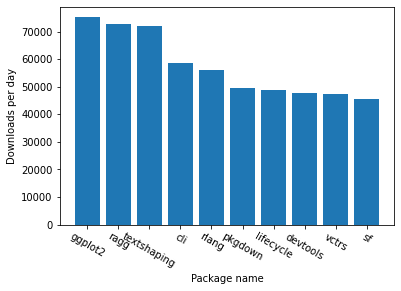

In [0]:
plt.bar(*data)
plt.xticks(rotation=-30)
plt.xlabel("Package name")
plt.ylabel("Downloads per day")

## Bonus

- What are the 10 most downloaded packages last month?
- What are the 10 most downloaded packages last year?

You can find all data here: http://cran-logs.rstudio.com/